In [1]:
# Library imports
import pandas as pd
import numpy as np
import os
import seaborn as sns

# Exploring Accidents

In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'Accidentes')

os.listdir(path)

['reclamos-ausa.csv',
 'documentacion-seguridad-vial.pdf',
 'intervenciones-de-seguridad-vial.csv']

## Reclamos a AUSA

In [3]:
reclamos = pd.read_csv(os.path.join(path, 'reclamos-ausa.csv'))
reclamos.head()

,nro_caso,titulo_caso,fecha
0,C00126163,RECLAMOS/VUELTO ERRONEO/FALTANTE,2016-12-01 15:47:26
1,C00126165,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./OBJETO,2016-12-01 16:01:31
2,C00126167,RECLAMOS/DAÑO EN VIA DE PEAJE/VÍA 07 A,2016-12-01 16:13:41
3,C00126169,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./AGRESIÓN ...,2016-12-01 16:35:22
4,C00126171,QUEJAS/TELEPEAJE/DISPOSICIONES DE SERVICIO,2016-12-01 17:15:12


In [4]:
reclamos.titulo_caso[0].split('/')

['RECLAMOS', 'VUELTO ERRONEO', 'FALTANTE']

In [5]:
reclamos['tema'] = [reclamo.split('/')[0] for reclamo in reclamos.titulo_caso]
reclamos['subtema'] = [reclamo.split('/')[1] for reclamo in reclamos.titulo_caso]
reclamos['detalle'] = [reclamo.split('/')[2] for reclamo in reclamos.titulo_caso]
reclamos.drop(columns=['nro_caso', 'titulo_caso'], inplace=True)

reclamos

,fecha,tema,subtema,detalle
0,2016-12-01 15:47:26,RECLAMOS,VUELTO ERRONEO,FALTANTE
1,2016-12-01 16:01:31,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,OBJETO
2,2016-12-01 16:13:41,RECLAMOS,DAÑO EN VIA DE PEAJE,VÍA 07 A
3,2016-12-01 16:35:22,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,AGRESIÓN POR TERCEROS
4,2016-12-01 17:15:12,QUEJAS,TELEPEAJE,DISPOSICIONES DE SERVICIO
...,...,...,...,...
5654,2019-04-20 10:00:21,QUEJAS,MALA ATENCION,A completar
5655,2019-04-20 15:00:24,QUEJAS,EN GENERAL,A completar
5656,2019-04-22 11:00:24,RECLAMOS,VUELTO ERRONEO,A completar
5657,2019-04-23 10:30:10,QUEJAS,PEAJE,A completar


In [6]:
reclamos['subtema'].value_counts().sort_index()

A completar                           1
A completar                           2
ACCIDENTE                             2
CONGESTIONAMIENTO                     6
DAÑO DE VEHÍCULO                      3
DAÑO DEL VEHICULO SOBRE AU.        1507
DAÑO DEL VEHICULO SOBRE AU.          65
DAÑO EN VIA DE PEAJE                701
DAÑO EN VIA DE PEAJE                 28
DAÑO EN VIA TELEPEAJE               589
DAÑO EN VIA TELEPEAJE                15
DISCONFORMIDAD CON EL SERVICIO       26
DISCONFORMIDAD CON EL SERVICIO        1
EN GENERAL                          306
EN GENERAL                           15
EXCEPCION DE PEAJE                   17
EXCEPCION DE PEAJE                    1
MALA ATENCION                       548
MALA ATENCION                        26
MANTENIMIENTO                         7
MANTENIMIENTO                         8
MANTENIMIENTO DE AU DE AUSA          90
MANTENIMIENTO DE AU DE AUSA          14
PEAJE                               445
PEAJE                                20


In [7]:
reclamos['subtema'] = reclamos['subtema'].str.strip()
reclamos['detalle'] = reclamos['detalle'].str.strip()
reclamos['subtema'].value_counts().sort_index()

A completar                          3
ACCIDENTE                            2
CONGESTIONAMIENTO                    6
DAÑO DE VEHÍCULO                     3
DAÑO DEL VEHICULO SOBRE AU.       1572
DAÑO EN VIA DE PEAJE               729
DAÑO EN VIA TELEPEAJE              604
DISCONFORMIDAD CON EL SERVICIO      27
EN GENERAL                         321
EXCEPCION DE PEAJE                  18
MALA ATENCION                      574
MANTENIMIENTO                       15
MANTENIMIENTO DE AU DE AUSA        104
PEAJE                              465
POLICIA                              2
SECTORES ANEXOS                    165
SEGURIDAD                            4
SEGURIDAD VIAL                       2
SEÑALIZACION DE AU DE AUSA          27
TELEPASE                            33
TELEPEAJE                           95
TELEPEAJE AUSA                       1
TELEPEAJE OTRAS AUTOPISTAS           4
VUELTO ERRONEO                     883
Name: subtema, dtype: int64

In [8]:
reclamos['subtema'][reclamos.subtema.str.contains('TEL')] = 'TELEPEAJE'
reclamos['subtema'][reclamos.subtema.str.contains('MANTE')] = 'MANTENIMIENTO'

In [9]:
reclamos['subtema'][reclamos.subtema.str.contains('MANTE')].value_counts()

MANTENIMIENTO    119
Name: subtema, dtype: int64

In [10]:
reclamos.subtema.value_counts()[reclamos.subtema.value_counts(normalize=True) < 0.01].sum() / len(reclamos)

0.016610708605760735

In [11]:
others = list(reclamos['subtema'].value_counts()[reclamos['subtema'].value_counts() < 10].index)
others

['CONGESTIONAMIENTO',
 'SEGURIDAD',
 'DAÑO DE VEHÍCULO',
 'A completar',
 'ACCIDENTE',
 'POLICIA',
 'SEGURIDAD VIAL']

In [12]:
reclamos['subtema'][reclamos.subtema.isin(others)] = 'OTROS'

In [13]:
reclamos.subtema.value_counts().sort_index()

DAÑO DEL VEHICULO SOBRE AU.       1572
DAÑO EN VIA DE PEAJE               729
DISCONFORMIDAD CON EL SERVICIO      27
EN GENERAL                         321
EXCEPCION DE PEAJE                  18
MALA ATENCION                      574
MANTENIMIENTO                      119
OTROS                               22
PEAJE                              465
SECTORES ANEXOS                    165
SEÑALIZACION DE AU DE AUSA          27
TELEPEAJE                          737
VUELTO ERRONEO                     883
Name: subtema, dtype: int64

In [14]:
reclamos[reclamos.tema.str.contains('a completar', case=False)].index

Int64Index([1527, 3988, 3989, 3990], dtype='int64')

In [15]:
reclamos.drop(index=reclamos[reclamos.tema.str.contains('a completar', case=False)].index, inplace=True)

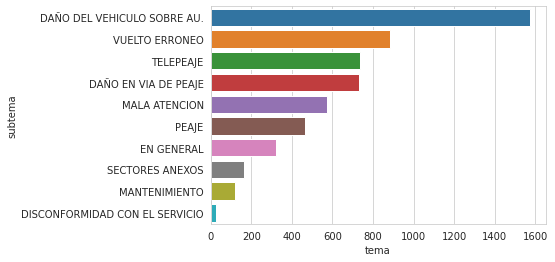

In [16]:
sns.set_style("whitegrid")
subtemas = reclamos.groupby('subtema').count().sort_values(by='tema', ascending=False).head(10)
sns.barplot(y=subtemas.index, x=subtemas.tema);

<AxesSubplot:xlabel='detalle'>

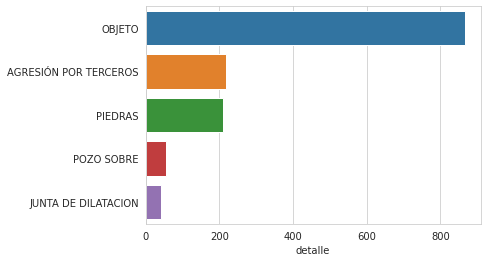

In [17]:
damages = reclamos[reclamos.subtema == 'DAÑO DEL VEHICULO SOBRE AU.'].detalle.value_counts().head()
sns.barplot(y=damages.index, x=damages)

## Accidentes

In [40]:
# Usar date parser para darle formato a las columnas de tiempo
accidents = pd.read_csv(os.path.join(path, 'intervenciones-de-seguridad-vial.csv'))
accidents.head()

,periodo,fecha,hora,autopista,banda_y_o_ramal,pk,condiciones_meteorologicas,superficie_de_la_via,lesionados,fallecidos,tipo_de_siniestro,moto,liviano,bus,camion
0,201401,2014-01-01,1,AU CAMPORA,ASCENDENTE,600,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,1,0,0
1,201401,2014-01-01,3,AU DELLEPIANE,DESCENDENTE,600,BUENO,SECA,0,0,COLISION CON OBSTACULO FIJO,0,1,0,0
2,201401,2014-01-01,22,AU 25 DE MAYO,ASCENDENTE,5900,BUENO,SECA,8,0,COLISION CON DOS O MAS VEHICULOS,0,2,0,0
3,201401,2014-03-01,7,AU CAMPORA,DESCENDENTE,600,BUENO,SECA,0,0,OBSTACULO NO FIJO,0,0,0,1
4,201401,2014-03-01,21,AU PERTIO MORENO,DESCENDENTE,5400,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,2,0,0


In [41]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   periodo                     6962 non-null   int64 
 1   fecha                       6962 non-null   object
 2   hora                        6962 non-null   int64 
 3   autopista                   6962 non-null   object
 4   banda_y_o_ramal             6962 non-null   object
 5   pk                          6962 non-null   object
 6   condiciones_meteorologicas  6962 non-null   object
 7   superficie_de_la_via        6962 non-null   object
 8   lesionados                  6962 non-null   int64 
 9   fallecidos                  6962 non-null   int64 
 10  tipo_de_siniestro           6962 non-null   object
 11  moto                        6962 non-null   int64 
 12  liviano                     6962 non-null   int64 
 13  bus                         6962 non-null   int6

In [51]:
accidents.fecha.unique()

array(['2014-01-01', '2014-03-01', '2014-04-01', ..., '25/02/2021',
       '26/02/2021', '28/02/2021'], dtype=object)